![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs Similarity </h1>

# 1. Business Problem 

## 1.1 Description 

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

## 1.2 Sources/Useful Links

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

## 1.3 Real world/Business Objectives and Constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

# 2. Machine Learning Probelm

##2.1 Data </h2>

### 2.1.1 Data Overview 

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

### 2.1.2 Example Data point 

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

## 2.2 Mapping the real world problem to an ML problem 

### 2.2.1 Type of Machine Leaning Problem 

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

### 2.2.2 Performance Metric

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

# 3. Exploratory Data Analysis and Feature Engineering

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import os
import gc
import re
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import warnings
import datetime as dt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
import sys
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
warnings.filterwarnings("ignore")
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## 3.1 Reading data and basic stats 

In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/"

 3_DonorsChoose_KNN.ipynb
 Clustering.ipynb
'Copy of parikshitgune@gmail.com_Assignment_6.ipynb'
 Dataset
 Decision_Tree.ipynb
 distance
 Keras_Mnist.ipynb
'parikshitgune@gmail (1).com_Assignment_3.ipynb'
 parikshitgune@gmail.com_Assignment_2.ipynb
 parikshitgune@gmail.com_Assignment_3.ipynb
 parikshitgune@gmail.com_Assignment_6.ipynb
 preprocessed_data.csv
 Quora_Case_Study
 Quora_Case_Study.ipynb
 temp.csv
 Untitled
 Untitled0.ipynb
'Untitled (1)'
 Untitled1.ipynb


In [0]:
df =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/Quora_Case_Study/train.csv')

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### 3.1.1 Very basic Data Description

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

### 3.1.2 Distribution of data points among output classes
- Number of duplicate(smilar) and non-duplicate(non similar) questions

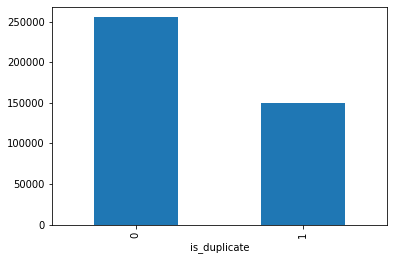

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [0]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


### 3.1.3 Number of unique questions 

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



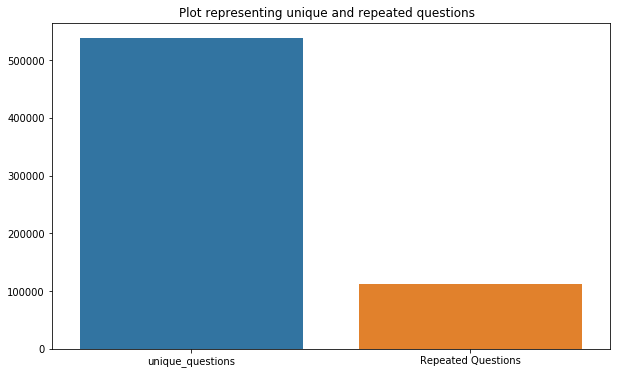

In [0]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### 3.1.4 Checking for Duplicates 

In [0]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### 3.1.5 Number of occurrences of each question

Maximum number of times a single question is repeated: 157



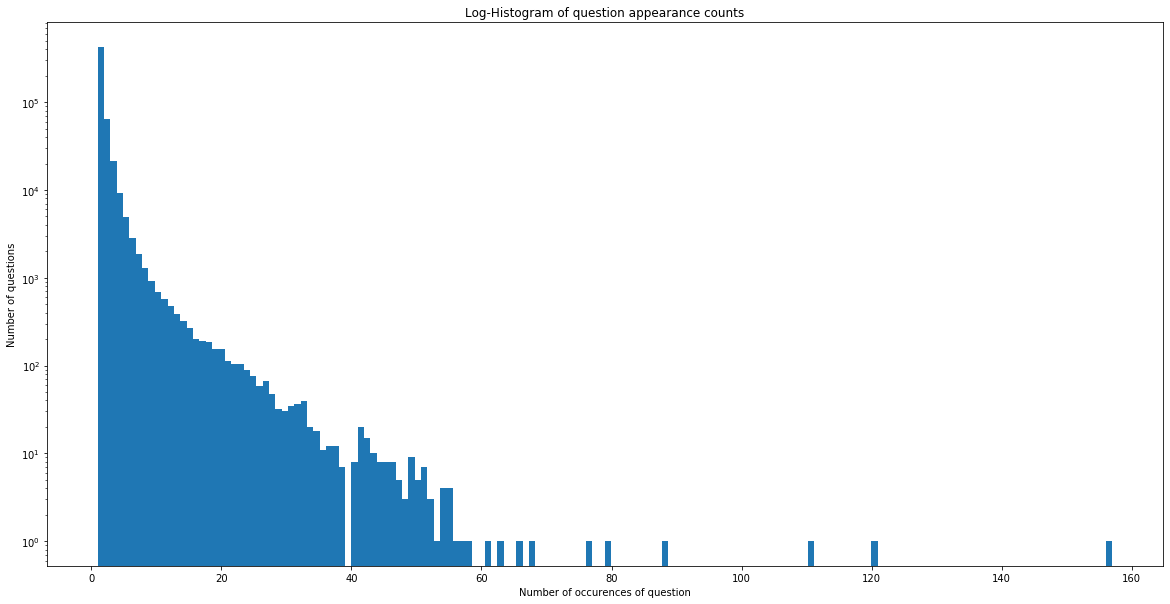

In [0]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### 3.1.6 Checking for NULL values 

In [0]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


- There are two rows with null values in question2 

In [0]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 3.2 Basic Feature Extraction (before cleaning) 

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [0]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### 3.2.1 Analysis of some of the extracted features 

- Here are some questions have only one single words.

In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


#### 3.2.1.1 Feature: word_share 

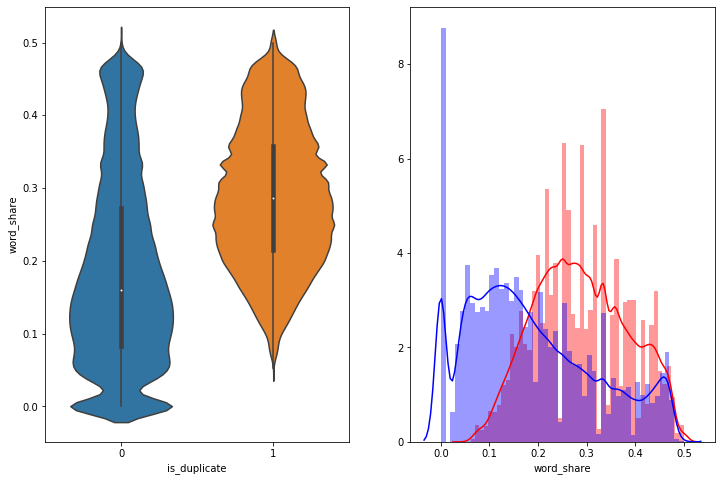

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

#### 3.2.1.2 Feature: word_Common 

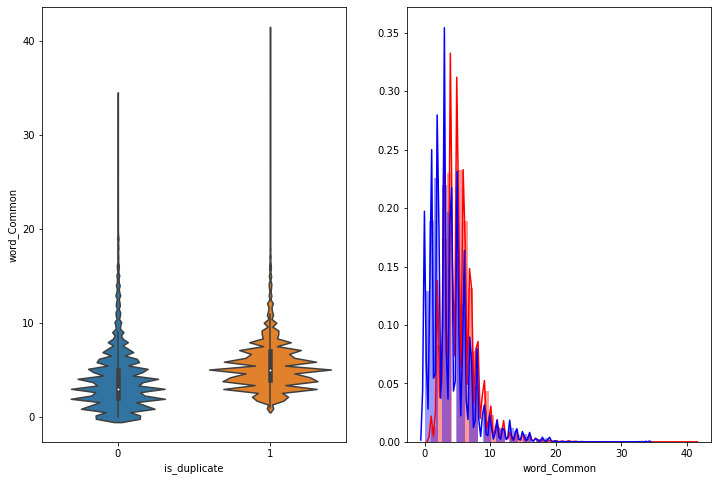

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## 3.3 Preprocessing of Text 

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

## 3.4 Advanced Feature Extraction (NLP and Fuzzy Features) 

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string
def lcsubstrings(seq1, seq2, positions=False):
    from array import array
    L1, L2 = len(seq1), len(seq2)
    ms = []
    mlen = last = 0
    if L1 < L2:
      seq1, seq2 = seq2, seq1
      L1, L2 = L2, L1
    
    column = array('L', range(L2))
    
    for i in range(L1):
      for j in range(L2):
        old = column[j]
        if seq1[i] == seq2[j]:
          if i == 0 or j == 0:
            column[j] = 1
          else:
            column[j] = last + 1
          if column[j] > mlen:
            mlen = column[j]
            ms = [(i, j)]
          elif column[j] == mlen:
            ms.append((i, j))
        else:
          column[j] = 0
        last = old
    
    if positions:
      return (mlen, tuple((i - mlen + 1, j - mlen + 1) for i, j in ms if ms))
    return set(seq1[i - mlen + 1:i + 1] for i, _ in ms if ms)



def get_longest_substr_ratio(a, b):
    strs = list(lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

extract_features(df)

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...,0,2,2,85,79,14,13,11.0,25.0,0.440000,4,0,0.857131,0.857131,0.999980,0.833319,0.846147,0.785709,1.0,1.0,1.0,13.5,97,88,91,87,0.387500
404286,404286,18840,155606,do you believe there is life after death,is it true that there is life after death,1,12,1,41,42,8,9,5.0,16.0,0.312500,13,11,0.666644,0.666644,0.599988,0.599988,0.624992,0.555549,1.0,0.0,1.0,8.5,79,69,72,76,0.642857
404287,404287,537928,537929,what is one coin,what is this coin,0,1,1,17,17,4,3,1.0,7.0,0.142857,2,0,0.999900,0.499975,0.999950,0.666644,0.749981,0.749981,1.0,1.0,0.0,4.0,86,79,79,76,0.444444
404288,404288,537930,537931,what is the approx annual cost of living while...,i am having little hairfall problem but i want...,0,1,1,94,127,17,25,1.0,40.0,0.025000,2,0,0.000000,0.000000,0.124998,0.099999,0.058823,0.040000,0.0,0.0,8.0,21.0,37,35,30,34,0.052632


In [0]:
df.to_csv(r'/content/drive/My Drive/Colab Notebooks/preprocessed_data.csv')

### 3.4.1 Analysis of extracted features

#### 3.4.1.1 Plotting Word clouds

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [0]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


Word Cloud for Duplicate Question pairs


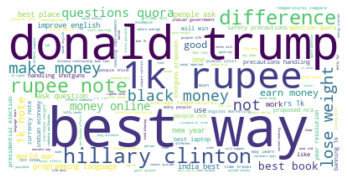

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


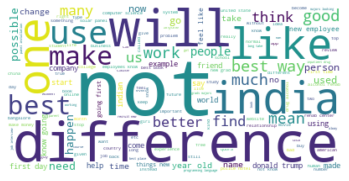

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 3.4.1.2 Pair plot of features

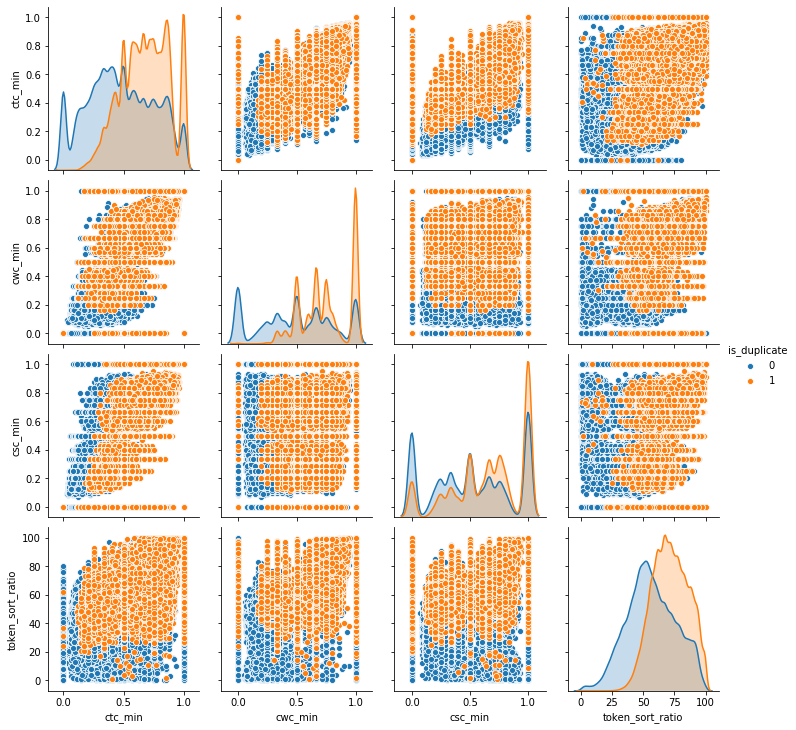

In [0]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

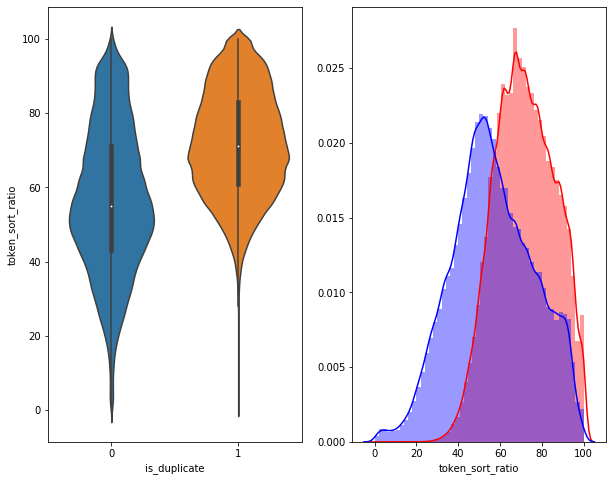

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

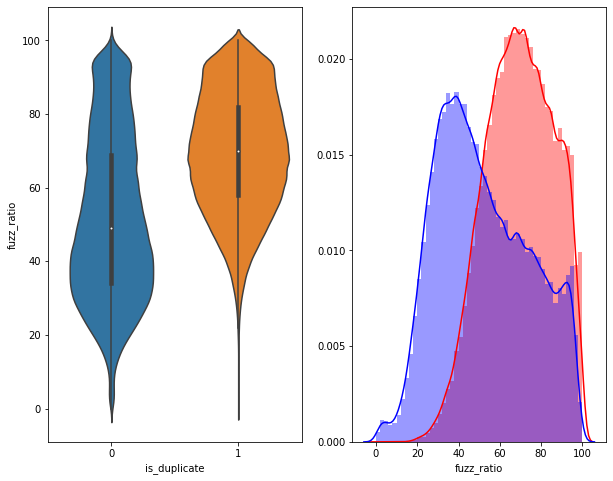

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### 3.4.2 Visualization 

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.023s...
[t-SNE] Computed neighbors for 5000 samples in 0.424s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.318s
[t-SNE] Iteration 50: error = 81.3425446, gradient norm = 0.0466835 (50 iterations in 1.696s)
[t-SNE] Iteration 100: error = 70.6490860, gradient norm = 0.0087385 (50 iterations in 1.281s)
[t-SNE] Iteration 150: error = 68.9494629, gradient norm = 0.0055224 (50 iterations in 1.196s)
[t-SNE] Iteration 200: error = 68.1286011, gradient norm = 0.0044136 (50 iterations in 1.245s)
[t-SNE] Iteration 250: error = 67.6222382, gradient norm = 0.0040027

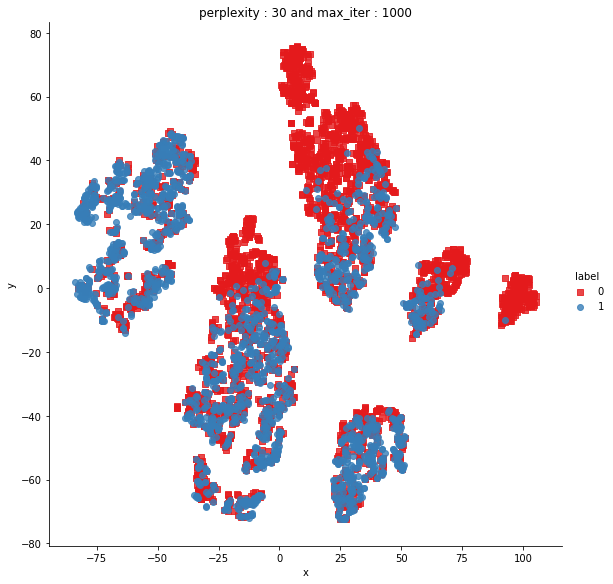

In [0]:
df1 = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df1, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.534s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.313s
[t-SNE] Iteration 50: error = 80.5739822, gradient norm = 0.0296227 (50 iterations in 6.882s)
[t-SNE] Iteration 100: error = 69.4160385, gradient norm = 0.0032520 (50 iterations in 3.204s)
[t-SNE] Iteration 150: error = 68.0035553, gradient norm = 0.0018662 (50 iterations in 2.934s)
[t-SNE] Iteration 200: error = 67.4419785, gradient norm = 0.0012061 (50 iterations in 2.914s)
[t-SNE] Iteration 250: error = 67.1313705, gradient norm = 0.0008775

In [0]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# 4. Machine Learning Models with TFIDF weighted W2V.

## 4.1 Train - Test split for different models </h2>

In [21]:
df =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_data.csv')

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [22]:
df = df.sample(n = 200000) 
df.shape[0]


200000

In [0]:
# avoid decoding problems
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
target = df['is_duplicate']
df = df.drop(['is_duplicate'], axis=1)

In [0]:
X_train=df.sample(frac=0.7,random_state=200) #random state is a seed value
X_test=df.drop(X_train.index)

y_train = X_train['is_duplicate']
y_test = X_test['is_duplicate']

X_train = X_train.drop(['is_duplicate'],axis =1)
X_test = X_test.drop(['is_duplicate'],axis =1)

In [30]:

print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)


(140000, 32)
(60000, 32)
(60000,)
(140000,)


### 4.1.1 Applying TFIDF encoding for train and test split

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [0]:
# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [33]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)


100%|██████████| 140000/140000 [22:56<00:00, 101.72it/s]


In [34]:
vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

100%|██████████| 140000/140000 [23:03<00:00, 101.23it/s]


In [35]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)


100%|██████████| 60000/60000 [09:50<00:00, 101.60it/s]


In [36]:
vecs2 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)

100%|██████████| 60000/60000 [10:01<00:00, 99.77it/s]


### 4.1.2 Merging all the data to form the final matrix

In [0]:
if not os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora_Case_Study/train_intd.csv'):
  X_train.to_csv(r'/content/drive/My Drive/Colab Notebooks/Quora_Case_Study/train_intd.csv')
if not os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora_Case_Study/test_intd.csv'):
  X_test.to_csv(r'/content/drive/My Drive/Colab Notebooks/Quora_Case_Study/test_intd.csv')

In [0]:
df_q1_train = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
df_q2_train = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)
df_q1_test = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
df_q2_test = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)

In [0]:
 df3_train = df3_q1_train.merge(df3_q2_train,how='left')

In [0]:
X_train_1 = X_train.drop(['q1_feats_m'],axis=1)
X_train_1 = X_train_1.drop(['q2_feats_m'],axis=1)
X_test_1 = X_test.drop(['q1_feats_m'],axis=1)
X_test_1 = X_test_1.drop(['q2_feats_m'],axis=1)

In [0]:
X_train_1  = pd.concat([X_train_1, df_q1_train,df_q2_train], axis=1, sort=False)

In [0]:
X_test_1  = pd.concat([X_test_1, df_q1_test,df_q2_test], axis=1, sort=False)

In [62]:
X_train_1.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0,1,2,3,4,5,6,7,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
127347,127347,127347,205036,205037,how have religions evolved in india,how did religions evolve,1,2,36,25,6,4,2.0,10.0,0.200000,3,1,0.499975,0.333322,0.499975,0.333322,0.499988,0.333328,0.0,1.0,2.0,5.0,70,68,71,84,0.653846,23.550573,60.840755,-69.447036,-60.106236,5.274826,38.828251,70.796257,57.184396,...,23.074458,-2.319464,-49.134710,75.501695,32.543928,14.017495,37.042719,-63.016982,16.833879,8.939170,-4.344710,90.066057,-26.859893,9.136092,-24.224760,18.629128,-11.359965,45.735194,4.032361,24.833519,18.077913,-60.006889,-20.379186,55.551271,-25.015708,-74.876555,-55.031892,10.136742,-16.277607,-89.027970,13.177469,-22.682565,24.362169,-25.854840,6.046995,14.188861,30.592662,-9.191367,13.540840,-5.868230
308368,308368,308368,432180,387183,what makes some students unable to fit in at y...,what makes some students unable to fit in at s...,1,2,50,54,10,10,9.0,20.0,0.450000,3,1,0.799984,0.799984,0.999980,0.999980,0.899991,0.899991,0.0,1.0,0.0,10.0,95,86,90,92,0.882353,92.970820,-54.213462,-52.315161,-125.488322,-0.827784,66.691054,70.510559,10.540013,...,2.533075,18.787561,-103.055550,64.360457,-54.563328,20.355815,42.715947,-68.545405,31.329697,65.067580,0.416058,-42.790707,-62.272687,3.919069,-55.544543,-13.097866,-104.872266,38.232577,88.466147,92.382555,22.178488,-45.873892,-46.455417,36.199152,-46.607175,-99.889837,-28.969956,3.646916,80.682557,-11.498402,82.964469,20.815722,78.664302,118.090954,45.421601,26.879386,18.118250,50.045918,-124.942725,20.443862
354953,354953,354953,53978,196520,what was your biggest mistake,what is your biggest mistake,5,7,30,29,5,5,4.0,10.0,0.400000,12,2,0.999950,0.999950,0.666644,0.666644,0.799984,0.799984,1.0,1.0,0.0,5.0,95,88,95,93,0.766667,-17.999813,-33.350548,60.283704,-13.360994,50.961065,7.654270,28.874214,17.730152,...,32.369778,27.253005,-5.202192,5.741826,-76.086653,17.476091,9.060929,-39.832545,25.724026,38.182206,16.109621,-8.590639,-81.243886,13.636327,-7.022975,46.519817,46.764669,71.251212,22.049639,89.254179,5.189700,-26.023397,-48.766608,-47.495433,-6.317232,32.661747,-55.517282,26.319923,26.580860,-11.406213,24.500012,-28.110421,31.733834,-19.532633,-11.334864,10.382339,-24.785008,-43.849999,36.047435,-10.049191
249155,249155,249155,362713,362714,where can i find donuts in warangal,what is the best donut at dunkin donuts,1,1,36,41,7,8,0.0,15.0,0.000000,2,0,0.333322,0.249994,0.000000,0.000000,0.142855,0.124998,0.0,0.0,1.0,7.5,46,46,37,42,0.216216,71.860221,-32.966144,-17.965373,-87.343752,-14.145268,1.479339,53.670940,-54.997414,...,21.522612,-8.650544,-49.471977,36.979632,-89.862751,-41.044512,116.046241,-42.249789,-11.272815,134.923157,-49.413132,64.573984,-65.492151,22.341820,-5.595306,4.891517,112.994997,104.241971,-17.337603,69.535881,11.649471,-42.097932,-128.862220,-98.754544,-42.738815,-62.751397,-109.506177,104.323893,70.569907,-63.042137,48.585138,-32.964420,81.104574,-7.039425,4.544914,-24.280126,-92.440829,27.248057,-62.211225,-17.683502
98674,98674,98674,163938,131784,how can i track a mobile number and the locati...,how do i trace the location of a mobile from w...,2,7,66,71,13,15,7.0,27.0,0.259259,9,5,0.399992,0.399992,0.624992,0.555549,0.538457,0.466664,0.0,1.0,2.0,14.0,69,70,55,56,0.208955,58.585224,-80.570237,-25.988859,-133.952480,-37.074597,70.832328,140.739212,18.407995,...,-37.260124,-43.851233,-111.681569,125.851281,-91.527352,-46.227070,25.406481,-50.835804,-77.385728,-1.093235,66.349289,111.656502,-74.728587,69.805527,41.803676,-67.212061,8.614240,154.796844,73.324193,93.217512,42.41

In [0]:
X_train = X_train_1.drop(['Unnamed: 0', 'qid1','qid2','question1','question2','id'], axis=1)
X_test = X_test_1.drop(['Unnamed: 0','qid1','qid2','question1','question2', 'id'], axis=1)

In [70]:
X_train.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0,1,2,3,4,5,6,7,8,9,10,11,12,13,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
127347,1,2,36,25,6,4,2.0,10.0,0.200000,3,1,0.499975,0.333322,0.499975,0.333322,0.499988,0.333328,0.0,1.0,2.0,5.0,70,68,71,84,0.653846,23.550573,60.840755,-69.447036,-60.106236,5.274826,38.828251,70.796257,57.184396,1.620790,31.179556,44.577081,21.225266,-33.921402,-34.654360,...,23.074458,-2.319464,-49.134710,75.501695,32.543928,14.017495,37.042719,-63.016982,16.833879,8.939170,-4.344710,90.066057,-26.859893,9.136092,-24.224760,18.629128,-11.359965,45.735194,4.032361,24.833519,18.077913,-60.006889,-20.379186,55.551271,-25.015708,-74.876555,-55.031892,10.136742,-16.277607,-89.027970,13.177469,-22.682565,24.362169,-25.854840,6.046995,14.188861,30.592662,-9.191367,13.540840,-5.868230
308368,1,2,50,54,10,10,9.0,20.0,0.450000,3,1,0.799984,0.799984,0.999980,0.999980,0.899991,0.899991,0.0,1.0,0.0,10.0,95,86,90,92,0.882353,92.970820,-54.213462,-52.315161,-125.488322,-0.827784,66.691054,70.510559,10.540013,-49.906660,47.161902,-19.639481,84.426947,-128.019039,-91.725973,...,2.533075,18.787561,-103.055550,64.360457,-54.563328,20.355815,42.715947,-68.545405,31.329697,65.067580,0.416058,-42.790707,-62.272687,3.919069,-55.544543,-13.097866,-104.872266,38.232577,88.466147,92.382555,22.178488,-45.873892,-46.455417,36.199152,-46.607175,-99.889837,-28.969956,3.646916,80.682557,-11.498402,82.964469,20.815722,78.664302,118.090954,45.421601,26.879386,18.118250,50.045918,-124.942725,20.443862
354953,5,7,30,29,5,5,4.0,10.0,0.400000,12,2,0.999950,0.999950,0.666644,0.666644,0.799984,0.799984,1.0,1.0,0.0,5.0,95,88,95,93,0.766667,-17.999813,-33.350548,60.283704,-13.360994,50.961065,7.654270,28.874214,17.730152,7.036416,-7.372329,-12.890350,19.299364,-31.711523,-8.771992,...,32.369778,27.253005,-5.202192,5.741826,-76.086653,17.476091,9.060929,-39.832545,25.724026,38.182206,16.109621,-8.590639,-81.243886,13.636327,-7.022975,46.519817,46.764669,71.251212,22.049639,89.254179,5.189700,-26.023397,-48.766608,-47.495433,-6.317232,32.661747,-55.517282,26.319923,26.580860,-11.406213,24.500012,-28.110421,31.733834,-19.532633,-11.334864,10.382339,-24.785008,-43.849999,36.047435,-10.049191
249155,1,1,36,41,7,8,0.0,15.0,0.000000,2,0,0.333322,0.249994,0.000000,0.000000,0.142855,0.124998,0.0,0.0,1.0,7.5,46,46,37,42,0.216216,71.860221,-32.966144,-17.965373,-87.343752,-14.145268,1.479339,53.670940,-54.997414,-15.620139,61.623228,-7.839373,-14.258692,-20.832398,-21.553617,...,21.522612,-8.650544,-49.471977,36.979632,-89.862751,-41.044512,116.046241,-42.249789,-11.272815,134.923157,-49.413132,64.573984,-65.492151,22.341820,-5.595306,4.891517,112.994997,104.241971,-17.337603,69.535881,11.649471,-42.097932,-128.862220,-98.754544,-42.738815,-62.751397,-109.506177,104.323893,70.569907,-63.042137,48.585138,-32.964420,81.104574,-7.039425,4.544914,-24.280126,-92.440829,27.248057,-62.211225,-17.683502
98674,2,7,66,71,13,15,7.0,27.0,0.259259,9,5,0.399992,0.399992,0.624992,0.555549,0.538457,0.466664,0.0,1.0,2.0,14.0,69,70,55,56,0.208955,58.585224,-80.570237,-25.988859,-133.952480,-37.074597,70.832328,140.739212,18.407995,-54.133974,59.355799,-45.610602,74.752954,-56.869569,-102.242779,...,-37.260124,-43.851233,-111.681569,125.851281,-91.527352,-46.227070,25.406481,-50.835804,-77.385728,-1.093235,66.349289,111.656502,-74.728587,69.805527,41.803676,-67.212061,8.614240,154.796844,73.324193,93.217512,42.415533,-61.420515,-93.951298,-53.794865,9.626200,-125.451686,-57.988233,44.326454,-11.045736,-78.716196,101.499092,-40.528226,50.416998,45.888649,-39.275420,-62.662875,8.370566,-1.468085,-59.124460,70.364442


In [0]:
if not os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora_Case_Study/final_train.csv'):
  X_train.to_csv(r'/content/drive/My Drive/Colab Notebooks/Quora_Case_Study/final_train.csv')
if not os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora_Case_Study/final_test.csv'):
  X_test.to_csv(r'/content/drive/My Drive/Colab Notebooks/Quora_Case_Study/final_test.csv')

## 4.2 Function for Confusion Matrix

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [84]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (140000, 218)
Number of data points in test data : (60000, 218)


In [83]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6286285714285714 Class 1:  0.3713714285714286
---------- Distribution of output variable in train data ----------
Class 0:  0.36866666666666664 Class 1:  0.36866666666666664


## 4.3 Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8840443791019684


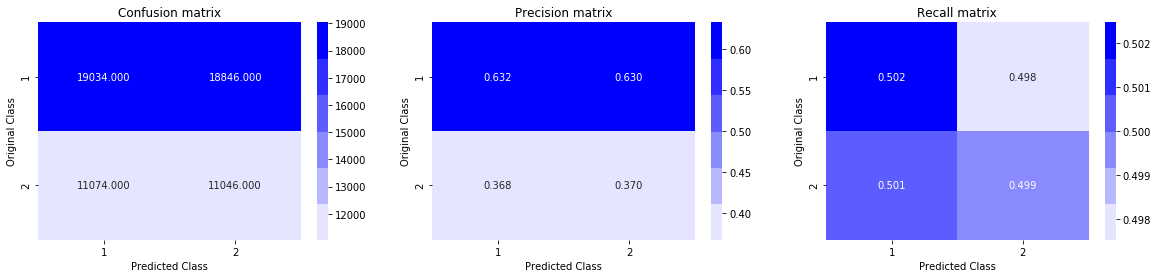

In [87]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [0]:
cols = list(X_train.columns)
print(cols)
cols = cols[:26]
print(cols)

for i in range(0,192):
  cols.append(i)
print(cols)
X_train.columns = cols
X_test.columns = cols

['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66

## 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.45027223657598414
For values of alpha =  0.0001 The log loss is: 0.4545649475194983
For values of alpha =  0.001 The log loss is: 0.44165800257812987
For values of alpha =  0.01 The log loss is: 0.440199887679728
For values of alpha =  0.1 The log loss is: 0.45612106964886423
For values of alpha =  1 The log loss is: 0.4875105003368997
For values of alpha =  10 The log loss is: 0.5319733984584966


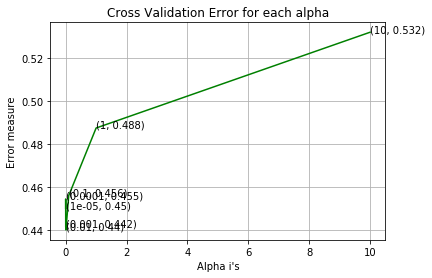

For values of best alpha =  0.01 The train log loss is: 0.4368737980492536
For values of best alpha =  0.01 The test log loss is: 0.440199887679728
Total number of data points : 60000


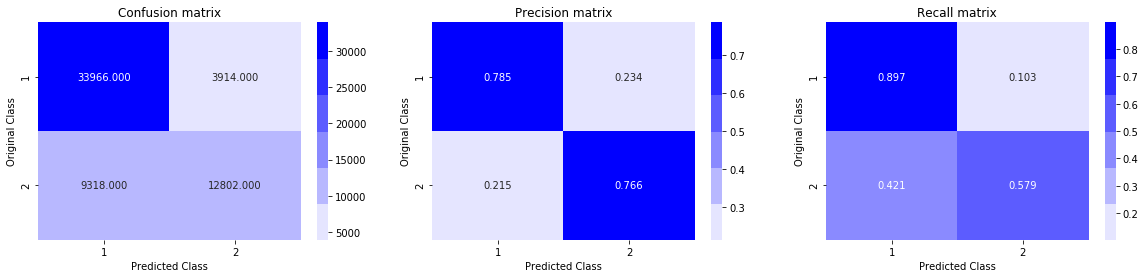

In [88]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.5 Linear SVM with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.6582580337532782
For values of alpha =  0.0001 The log loss is: 0.6582580337532782
For values of alpha =  0.001 The log loss is: 0.6132187766453454
For values of alpha =  0.01 The log loss is: 0.4856902335931287
For values of alpha =  0.1 The log loss is: 0.6381689591362368
For values of alpha =  1 The log loss is: 0.6582580337532782
For values of alpha =  10 The log loss is: 0.6582580337532782


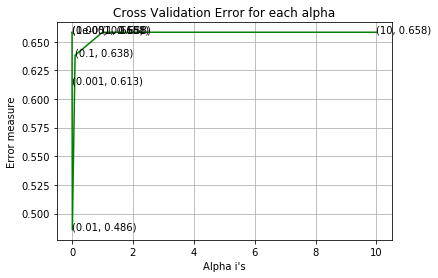

For values of best alpha =  0.01 The train log loss is: 0.48466300152331554
For values of best alpha =  0.01 The test log loss is: 0.4856902335931287
Total number of data points : 60000


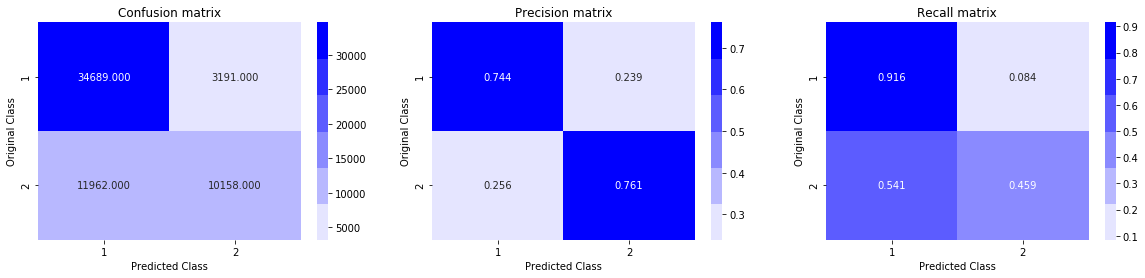

In [90]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.6 XGBoost

In [102]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684832	valid-logloss:0.684868
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615529	valid-logloss:0.615335
[20]	train-logloss:0.564803	valid-logloss:0.564733
[30]	train-logloss:0.526987	valid-logloss:0.526846
[40]	train-logloss:0.497798	valid-logloss:0.497793
[50]	train-logloss:0.474858	valid-logloss:0.474917
[60]	train-logloss:0.45646	valid-logloss:0.456523
[70]	train-logloss:0.441793	valid-logloss:0.441963
[80]	train-logloss:0.429882	valid-logloss:0.430114
[90]	train-logloss:0.420277	valid-logloss:0.420536
[100]	train-logloss:0.412356	valid-logloss:0.412597
[110]	train-logloss:0.405677	valid-logloss:0.406009
[120]	train-logloss:0.400053	valid-logloss:0.400453
[130]	train-logloss:0.395414	valid-logloss:0.395908
[140]	train-logloss:0.391206	valid-logloss:0.391795
[150]	train-logloss:0.387706	valid-logloss:0.388428
[160]	train-logloss:0.384706	

# 5. Machine Learning Models with TFIDF Encoding

## 5.1 Train-Test Split for Different Models

In [0]:
df =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_data.csv')

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [0]:
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [0]:
target = df['is_duplicate']
df = df.drop(['is_duplicate'], axis=1)

In [0]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.30, stratify=target)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)


(283003, 32)
(121287, 32)
(121287,)
(283003,)


### 5.1.1 Applying TFIDF encoding for train and test split

In [0]:
X_train['question1'] = X_train['question1'].apply(lambda x: str(x))
X_train['question2'] = X_train['question2'].apply(lambda x: str(x))
X_test['question1'] = X_test['question1'].apply(lambda x: str(x))
X_test['question2'] = X_test['question2'].apply(lambda x: str(x))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_train = list(X_train['question1']) + list(X_train['question2'])
questions_test = list(X_test['question1']) + list(X_test['question2'])

tfidf = TfidfVectorizer(min_df = 10)
tfidf.fit(questions_train)

que1_train = tfidf.transform(X_train['question1'])
que2_train = tfidf.transform(X_train['question2'])

tfidf.fit(questions_test)

que1_test = tfidf.transform(X_test['question1'])
que2_test = tfidf.transform(X_test['question2'])


In [0]:
X_train = X_train.drop(['qid1','qid2','question1','question2'],axis=1)
X_test = X_test.drop(['qid1','qid2','question1','question2'],axis=1)


### 5.1.2 Merging all the data to form the final matrix

In [0]:
question_train = hstack((que1_train,que2_train))
df_train = hstack((X_train, question_train),format="csr",dtype='float64')
question_test = hstack((que1_test,que2_test))
df_test = hstack((X_test, question_test),format="csr",dtype='float64')

In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


---------------------------------------------------------------------

## 5.2 Random Model

Log loss on Test Data using Random Model 0.8844277261827556


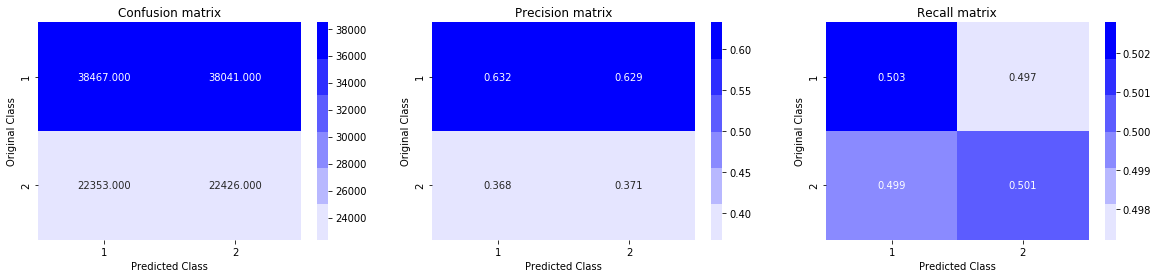

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## 5.3 Logistic Regression with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.6585278256547589
For values of alpha =  0.0001 The log loss is: 0.6585278256547589
For values of alpha =  0.001 The log loss is: 0.6585278256547589
For values of alpha =  0.01 The log loss is: 0.6585278256547589
For values of alpha =  0.1 The log loss is: 0.6452448534263525
For values of alpha =  1 The log loss is: 0.6079355142413466
For values of alpha =  10 The log loss is: 0.6479876132488148


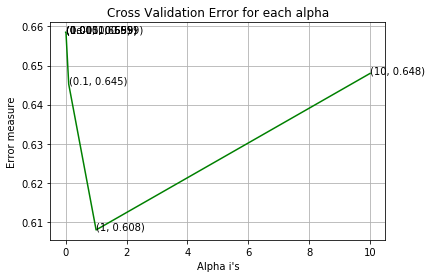

For values of best alpha =  1 The train log loss is: 0.6075278270966709
For values of best alpha =  1 The test log loss is: 0.6079355142413466
Total number of data points : 121287


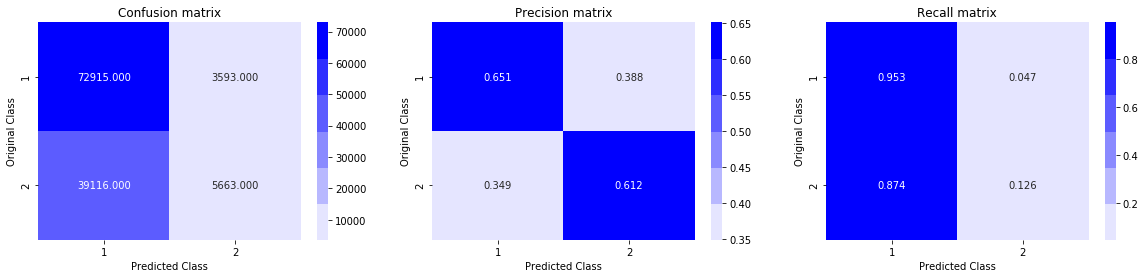

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 5.4 Linear SVM with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.6585278256547589
For values of alpha =  0.0001 The log loss is: 0.6585278256547589
For values of alpha =  0.001 The log loss is: 0.6585278256547589
For values of alpha =  0.01 The log loss is: 0.6585278256547589
For values of alpha =  0.1 The log loss is: 0.6585278256547589
For values of alpha =  1 The log loss is: 0.6025024958975239
For values of alpha =  10 The log loss is: 0.6432710529301564


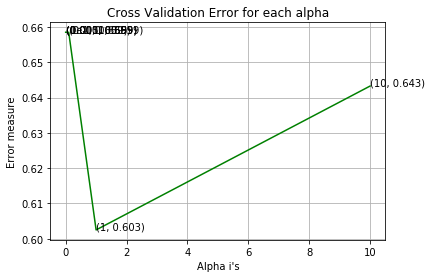

For values of best alpha =  1 The train log loss is: 0.6019254083869978
For values of best alpha =  1 The test log loss is: 0.6025024958975239
Total number of data points : 121287


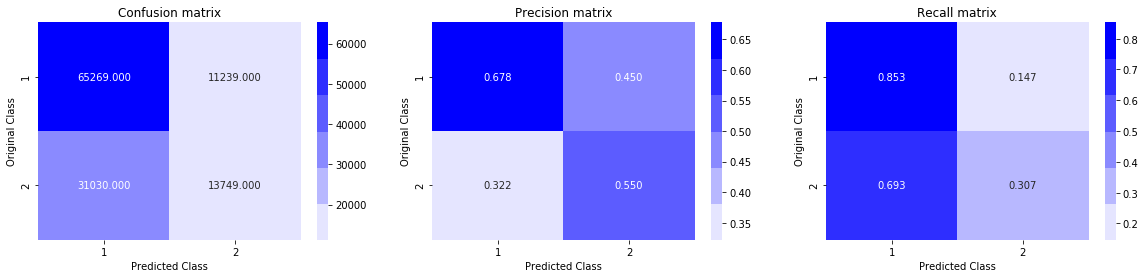

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 5.5 XGBoost Model

### 5.5.1 Sampling and Splitting data 

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [0]:
# taking first 100000 points

X_train = X_train[:100000]
X_test = X_test[:100000]
y_test = y_test[:100000]
y_train = y_train[:100000]

In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.63128 Class 1:  0.36872
---------- Distribution of output variable in train data ----------
Class 0:  0.36768 Class 1:  0.36768


### 5.5.2 Hyperparameter Tuning

In [0]:
n_estimators = [50, 250, 450, 650, 850, 1050, 1250, 1450]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
col_sample = [0.1, 0.3, 0.5, 0.7 , 0.9, 1]
subsample = [0.1,0.3,0.5,0.7,0.9,1]
def hp_tuning(X,Y):
  param_grid = dict(learning_rate=learning_rate,n_estimators=n_estimators,col_sample = col_sample,subsample = subsample)
  model = XGBClassifier(nthread=-1)
  k_fold = StratifiedKFold(n_splits=4, shuffle=True)
  random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=k_fold)
  result = random_search.fit(X,Y)
  # Summarize results
  print("Best: %f using %s" % (result.best_score_, result.best_params_))
  print()
  means = result.cv_results_['mean_test_score']
  stds = result.cv_results_['std_test_score']
  params = result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
  return result

In [0]:
result = hp_tuning(X_train,y_train)


Best: -0.338471 using {'subsample': 0.5, 'n_estimators': 850, 'learning_rate': 0.1, 'col_sample': 0.9}

-0.384034 (0.005078) with: {'subsample': 0.1, 'n_estimators': 1450, 'learning_rate': 0.2, 'col_sample': 0.3}
-0.339605 (0.001924) with: {'subsample': 0.7, 'n_estimators': 650, 'learning_rate': 0.2, 'col_sample': 0.5}
-0.613959 (0.000458) with: {'subsample': 0.5, 'n_estimators': 250, 'learning_rate': 0.001, 'col_sample': 0.3}
-0.361714 (0.002433) with: {'subsample': 0.3, 'n_estimators': 850, 'learning_rate': 0.01, 'col_sample': 0.5}
-0.377730 (0.001007) with: {'subsample': 0.1, 'n_estimators': 450, 'learning_rate': 0.3, 'col_sample': 0.5}
-0.338471 (0.001925) with: {'subsample': 0.5, 'n_estimators': 850, 'learning_rate': 0.1, 'col_sample': 0.9}
-0.649802 (0.000214) with: {'subsample': 0.1, 'n_estimators': 1250, 'learning_rate': 0.0001, 'col_sample': 0.5}
-0.676506 (0.000133) with: {'subsample': 0.9, 'n_estimators': 450, 'learning_rate': 0.0001, 'col_sample': 0.3}
-0.413155 (0.001653) 

### 5.5.3 Running XGB classifier

In [0]:
xGBClassifier = XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=1250,subsample=1,col_sample= 1,nthread=-1)

In [0]:
import xgboost as XGBClassifier

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4
params['col_sample'] = 0.9
params['n_estimators'] = 850
params['subsample'] = 0.5
params['learning_rate'] = 0.1
params['nthread'] = -1
params['silent'] = 1
d_train = XGBClassifier.DMatrix(X_train, label=y_train)
d_test = XGBClassifier.DMatrix(X_test, label=y_test)
watchlist = [(d_train, 'train'), (d_test, 'valid')]
bst = XGBClassifier.train(params, d_train, 400, watchlist,verbose_eval= 10,early_stopping_rounds=20)
xgdmat = XGBClassifier.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


[0]	train-logloss:0.65299	valid-logloss:0.653179
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.462033	valid-logloss:0.463519
[20]	train-logloss:0.404986	valid-logloss:0.407661
[30]	train-logloss:0.381619	valid-logloss:0.385009
[40]	train-logloss:0.369712	valid-logloss:0.373505
[50]	train-logloss:0.362221	valid-logloss:0.36647
[60]	train-logloss:0.356621	valid-logloss:0.361325
[70]	train-logloss:0.351606	valid-logloss:0.356738
[80]	train-logloss:0.348066	valid-logloss:0.353609
[90]	train-logloss:0.345314	valid-logloss:0.351481
[100]	train-logloss:0.342703	valid-logloss:0.349513
[110]	train-logloss:0.340826	valid-logloss:0.34812
[120]	train-logloss:0.339076	valid-logloss:0.346919
[130]	train-logloss:0.33726	valid-logloss:0.345669
[140]	train-logloss:0.335752	valid-logloss:0.344776
[150]	train-logloss:0.334546	valid-logloss:0.344182
[160]	train-logloss:0.333049	val

Total number of data points : 100000


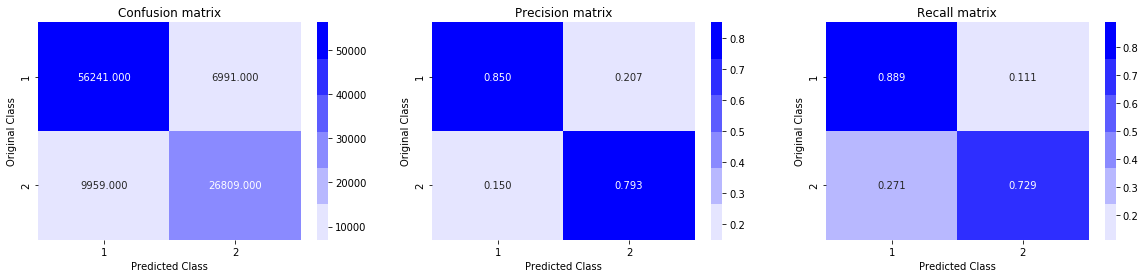

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 6. Summary of the Case Study

In [103]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ['Model','Number of data points','Text Encoding','Hyperparameter Tunning', 'Test Log Loss']
table.add_row(["Random","~100k","TFIDF Weighted W2V","No","0.8840"])
table.add_row(["Logistic Regression","~100k","TFIDF Weighted W2V","Yes","0.4401"])
table.add_row(["Linear SVM","~100k","TFIDF Weighted W2V","Yes","0.4856"])
table.add_row(["XGBoost","~100k","TFIDF Weighted W2V","No","0.3548"])
table.add_row(["\n","\n","\n","\n","\n"])
table.add_row(["Random","~400k","TFIDF","No","0.8844"])
table.add_row(["Logistic Regression","~400k","TFIDF","Yes","0.6079"])
table.add_row(["Linear SVM","~400k","TFIDF","Yes","0.6025"])
table.add_row(["XGBoost","~100k","TFIDF","Yes","0.3389"])
print(table)

+---------------------+-----------------------+--------------------+------------------------+---------------+
|        Model        | Number of data points |   Text Encoding    | Hyperparameter Tunning | Test Log Loss |
+---------------------+-----------------------+--------------------+------------------------+---------------+
|        Random       |         ~100k         | TFIDF Weighted W2V |           No           |     0.8840    |
| Logistic Regression |         ~100k         | TFIDF Weighted W2V |          Yes           |     0.4401    |
|      Linear SVM     |         ~100k         | TFIDF Weighted W2V |          Yes           |     0.4856    |
|       XGBoost       |         ~100k         | TFIDF Weighted W2V |           No           |     0.3548    |
|                     |                       |                    |                        |               |
|                     |                       |                    |                        |               |
|        R